In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import os

import gfdl_utils.core as gu
import CM4Xutils
import cftime
import numpy as np
import pandas as pd
import xarray as xr
import xgcm
import xhistogram
import xwmt

import cmocean
import matplotlib.colors as colors
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import matplotlib.dates as mdates
plt.rcParams.update({'font.size': 11})

In [3]:
include_piControl=False

In [4]:
from common import *
grids = load_datasets()

grid = grids["CM4Xp125_forced"]
wm = xwmt.WaterMass(grid)
wm.get_density("sigma2");
grid = wm.grid # reassign grid since we have modified a copy within wm
ds = grid._ds # reassign ds since we have modified a copy within grid
ds["z"] = ds.z.transpose("year", "zl", "yh", "xh")

grid_p25 = grids["CM4Xp25_forced"]
wm_p25 = xwmt.WaterMass(grid_p25)
wm_p25.get_density("sigma2");
grid_p25 = wm_p25.grid # reassign grid since we have modified a copy within wm
ds_p25 = grid_p25._ds # reassign ds since we have modified a copy within grid
ds_p25["z"] = ds_p25.z.transpose("year", "zl", "yh", "xh")

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [5]:
grid._ds["fgcfc11_annual"] = grid._ds["fgcfc11"].groupby("time.year").mean()
grid._ds["fgcfc11_annual"] = grid._ds["fgcfc11_annual"].where(grid._ds["deptho"]!=0, np.nan)

always_sink = (grid._ds["fgcfc11_annual"] > -1e-18).rolling({"year":10}, min_periods=1).mean("year").all("year").compute()
source_year = (grid._ds["fgcfc11_annual"].rolling({"year":10}, min_periods=1).mean("year") <= -1e-18).idxmax("year")
source_year = source_year.where((~always_sink) & (grid._ds.deptho!=0))

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/dask/core.py:127: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [6]:
inv_dict = {}

for model in models.keys():
    inv_path = f"../data/interim/transient_tracer_inventory_{model}-SSP585.nc"
    if os.path.exists(inv_path):
        print(f"Loading inert tracer inventories for {model} (forced historical + SSP5-8.5)")
        inv_dict[model] = xr.open_dataset(inv_path)

if include_piControl:
    print(f"Loading inert tracer inventories for CM4Xp125 (piControl)")
    inv_dict["CM4Xp125-piControl"] = xr.open_dataset("../data/interim/transient_tracer_inventory_CM4Xp125-piControl.nc")
    # align times with historical + SSP5-8.5
    inv_dict["CM4Xp125-piControl"] = inv_dict["CM4Xp125-piControl"].assign_coords(
        {"time": inv_dict["CM4Xp125"].time[0:inv_dict["CM4Xp125-piControl"].time.size]}
    )

Loading inert tracer inventories for CM4Xp25 (forced historical + SSP5-8.5)
Loading inert tracer inventories for CM4Xp125 (forced historical + SSP5-8.5)


In [7]:
bc = xr.open_dataset("/archive/hfd/datasets/input_files/CFC_SSP585_20x20deg.20220203.nc", decode_times=False)
bc = bc.assign_coords({'Year': bc['Time'].copy() + 1601})
bc['Year'].attrs = {}
bc['Time'] = bc['Time']*365.242198781
bc['Time'].attrs['units'] = 'days since 1601-01-01 00:00:00'
bc = xr.decode_cf(bc, use_cftime=True)

In [8]:
glo = xr.open_dataset("../data/obs/glodap_v1/glodap_cfc.nc") # CFC concentrations [pmol / kg]

# Estimate volumes of data cells
glo['dz'] = xr.ones_like(glo['depth'])
glo['dz'].data = np.diff(glo['depth_bnds'])
R = 6378.1e3 # radius of Earth in meters
glo['dA'] = R**2 * np.abs(np.sin(np.deg2rad(glo['lat']+0.5)) - np.sin(np.deg2rad(glo['lat']-0.5))) * np.deg2rad((glo['lon']+0.5) - (glo['lon']-0.5))
glo['volcello'] = glo.dz * glo.dA

mol_per_pmol = 1e-12
rho0 = 1035. # reference density [kg/m^3]
glo['CFC11_inv'] = (glo.CFC11*mol_per_pmol*rho0 * glo.volcello).sum()
glo['CFC12_inv'] = (glo.CFC12*mol_per_pmol*rho0 * glo.volcello).sum()

In [9]:
wang2021_path = "../data/Wang2021_MITgcm_CFCs/data/" # Downloaded from Zenodo linked in paper
wang2021_CFC11 = pd.read_csv(f"{wang2021_path}MITgcm_rcp_forcing_sensitivity_inventory_CFC11.csv")
wang2021_CFC12 = pd.read_csv(f"{wang2021_path}MITgcm_rcp_forcing_sensitivity_inventory_CFC12.csv")

years = np.array(wang2021_CFC11['Year'], dtype=int)
wang2021_CFC11["Date"] = np.array([cftime.datetime(year=year, month=1, day=1) for year in years])
wang2021_CFC12["Date"] = np.array([cftime.datetime(year=year, month=1, day=1) for year in years])

mass_atm = 5.148e12            # mass of atmosphere, unit in Gg
molar_mass_air = 28.8          # average air molar mass unit in g/mol
molar_mass_CFC11 = g_per_mol["cfc11"]      # CFC11 molar mass, unit in g/mol
molar_mass_CFC12 = g_per_mol["cfc12"]      # CFC12 molar mass, unit in g/mol

ppt_to_Gg11 = (0.95*mass_atm/(molar_mass_air/molar_mass_CFC11) )*1e-12/1.07  # unit transfer from ppt to Gg
Gg_to_ppt11 = 1/ppt_to_Gg11 

ppt_to_Gg12 = (0.95*mass_atm/(molar_mass_air/molar_mass_CFC12) )*1e-12/1.07  # unit transfer from ppt to Gg
Gg_to_ppt12 = 1/ppt_to_Gg12 

In [10]:
obs_AGAGE = pd.read_csv(f"{wang2021_path}mf_CFC-11_obs.csv", header=3, skipinitialspace=True)
Time_cf = []
for t in obs_AGAGE['Time']:
    year = np.int64(np.floor(t))
    month = np.int64(np.floor((t - year)*12)+1)
    day = np.int64(np.floor((t - year - (month-1)/12)*30))
    Time_cf.append(cftime.datetime(year=year, month=month, day=day))
Time_cf = np.array(Time_cf)

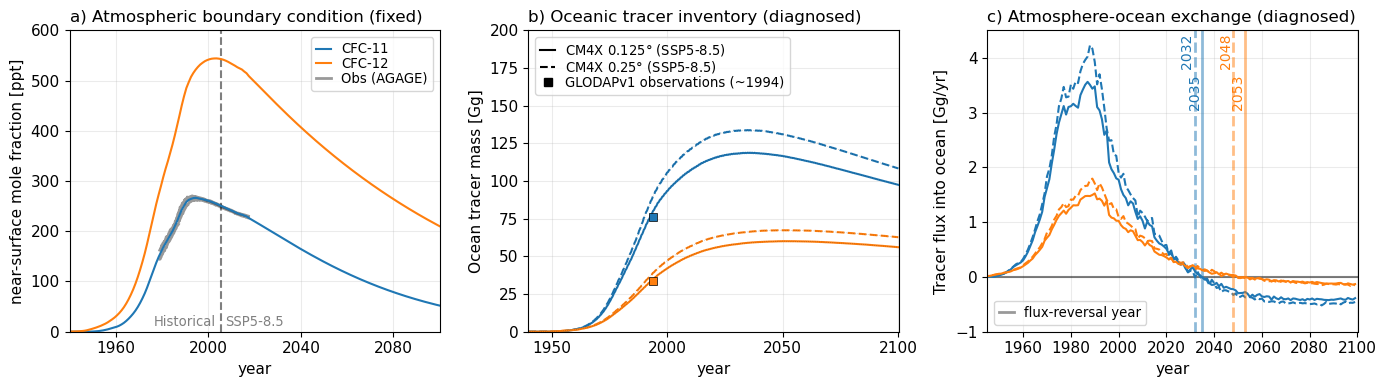

In [11]:
tracer_names = ["cfc11", "cfc12"]
cols = {'cfc11':'C0', 'cfc12':'C1'}
labels = {'cfc11':'CFC11', 'cfc12':'CFC12'}
long_labels = {'cfc11':'CFC-11', 'cfc12':'CFC-12'}
long_exps = {'historical': 'Historical', 'ssp585':'SSP5-8.5'}

yscale = "linear"
ylim1 = [0., 600]
ylim2 = [0., 200]


fig = plt.figure(figsize=(14, 4))

ax = plt.subplot(1,3,1)
plt.plot(Time_cf, obs_AGAGE['90S-30S'], color="k", alpha=0.4, lw=2)
plt.plot(Time_cf, obs_AGAGE['30N-90N'], color="k", alpha=0.4, lw=2)
plt.axvline(2014, linestyle="--", color="k", alpha=0.5, linewidth=1.5)
for ((_, long_label), (tr, label)) in zip(long_labels.items(), labels.items()):
    line = bc[label].mean(['Longitude', 'Latitude']).plot(label=long_label, color=cols[tr])
    timax = bc[label].mean(['Longitude', 'Latitude']).argmax()

plt.plot([], [], color="k", alpha=0.4, lw=2, label="Obs (AGAGE)")
plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
plt.grid(True, alpha=0.25, which="major", lw=0.75)
plt.grid(True, alpha=0.15, which="minor")
plt.ylabel("near-surface mole fraction [ppt]")
plt.annotate(long_exps['historical'], xy=(0.395, 0.01), xycoords="axes fraction", ha="right", va="bottom", color="gray", fontsize=9.5)
plt.annotate(long_exps['ssp585'], xy=(0.42, 0.01), xycoords="axes fraction", ha="left", va="bottom", color="gray", fontsize=9.5)
plt.legend(labelspacing=0.06, handlelength=1.1, fontsize=9.5, loc="upper right")
plt.ylim(ylim1)
plt.yscale(yscale)
plt.xlabel("year")
plt.title("a) Atmospheric boundary condition (fixed)", fontsize=12, loc="left")

ax = plt.subplot(1,3,2)
for (model, inv), ls in zip(inv_dict.items(), ["--", "-", ":"]):
    for tr in tracer_names:
        line = plt.plot(
            inv['time'],
            inv[f'{tr}_volumeint'] * g_per_mol[tr] * Gg_per_g ,
            color=cols[tr], ls=ls
        )
        timax = inv[f'{tr}_volumeint'].argmax()
        (inv[f'fg{tr}_areatimeint'] * g_per_mol[tr] * Gg_per_g ).plot(
            color="k", ls=":", alpha=0.3, lw=0.5
        )

for tr, color in zip(['cfc11', 'cfc12'], ["C0", "C1"]):
    plt.plot(
        cftime.datetime(1994, 1, 1),
        glo[f'{labels[tr]}_inv'] * g_per_mol[tr] * Gg_per_g ,
        marker="s", color=color, markeredgecolor="k", markeredgewidth=0.5
    )
plt.xlim([cftime.datetime(1940, 1, 1), cftime.datetime(2100, 1, 1)])
plt.grid(True, alpha=0.25, which="major", lw=0.75)
plt.grid(True, alpha=0.15, which="minor", lw=0.25)
plt.ylabel(r"Ocean tracer mass [Gg]")
plt.plot([], [], ls="-", color="k", label=r"CM4X 0.125$\degree$ (SSP5-8.5)")
plt.plot([], [], ls="--", color="k", label=r"CM4X 0.25$\degree$ (SSP5-8.5)")
if include_piControl: plt.plot([], [], ls=":", color="k", label=r"CM4X 0.125$\degree$ (piControl)")

#plt.plot([], [], ls="-.", color="k", alpha=0.4, lw=0.5, label=r"$\int \left( \iint\,F_{c} \, dA \right) \, dt$")
plt.plot([], [], "ks", label=r"GLODAPv1 observations (~1994)")
plt.legend(labelspacing=0.06, handlelength=1.1, fontsize=9.5, loc="upper left")
plt.xlabel("year")
plt.ylim(ylim2)
plt.yscale(yscale)
plt.title("b) Oceanic tracer inventory (diagnosed)", fontsize=12, loc="left")

plt.subplot(1,3,3)
plt.axhline(0., color="k", lw=1.5, alpha=0.5)
for pidx, ((model, inv), ls) in enumerate(zip(inv_dict.items(), ["--", "-", ":"])):
    for tr in tracer_names:
        tr_flux = inv[f'fg{tr}_areaint'].groupby("time.year").mean("time") * g_per_mol[tr] * sec_per_year * Gg_per_g
        line = tr_flux.plot(ls=ls, color=cols[tr])
        reversal_year = tr_flux['year'].isel(year=np.abs(tr_flux).where(tr_flux['year'] > 2000).argmin())
        plt.axvline(reversal_year, color=line[0].get_color(), ls=ls, alpha=0.5, lw=2)
        plt.annotate(str(reversal_year.values), (reversal_year-0.25, 4.45 -0.75*pidx), rotation="vertical", ha="right", va="top", color=line[0].get_color(), fontsize=10)

plt.plot([], [], color="k", alpha=0.4, lw=2, label="flux-reversal year")
plt.legend(labelspacing=0.06, handlelength=1.1, fontsize=9.5)
plt.xlim([1945, 2100])
plt.ylim(-1, 4.5)
plt.grid(True, alpha=0.25, which="major", lw=0.75)
plt.grid(True, alpha=0.15, which="minor", lw=0.25)
plt.ylabel("Tracer flux into ocean [Gg/yr]")
plt.title("c) Atmosphere-ocean exchange (diagnosed)", fontsize=12, loc="left")

plt.tight_layout()
plt.savefig(f"../figures/Fig1_CFC_boundary_boundary_conditions_and_fluxes.png", dpi=300., bbox_inches="tight")

In [12]:
# Add Wang et al. projection and observations as comparison
# plt.plot(wang2021_CFC11['Date'], wang2021_CFC11['hist_atm']*Gg_to_ppt11, linestyle="--", alpha=0.8)
# plt.plot(wang2021_CFC12['Date'], wang2021_CFC12['hist_atm']*Gg_to_ppt12, linestyle="--", alpha=0.8)
# plt.fill_between(Time_cf, obs_AGAGE['90S-30S'], obs_AGAGE['30N-90N'], facecolor="k", alpha=0.7, label="Obs (AGAGE)")

In [13]:
import doralite
sg = xr.open_dataset("/archive/Raphael.Dussin/datasets/OM4p125/mosaic_c192_om4p125_bedmachine_v20210310_hydrographyKDunne20210614_unpacked/ocean_hgrid.nc")
og = gu.open_static(doralite.dora_metadata("odiv-255")["pathPP"], "ocean_annual")

In [14]:
og = og.assign_coords({
    'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
    'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
    'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
    'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
    'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])
})

/vftmp/Henri.Drake/pid10200/ipykernel_5972/2309735818.py:54: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(
/vftmp/Henri.Drake/pid10200/ipykernel_5972/2309735818.py:75: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pc = plt.pcolormesh(
/vftmp/Henri.Drake/pid10200/ipykernel_5972/2309735818.py:83: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(
/vftmp/Henri.Drake/p

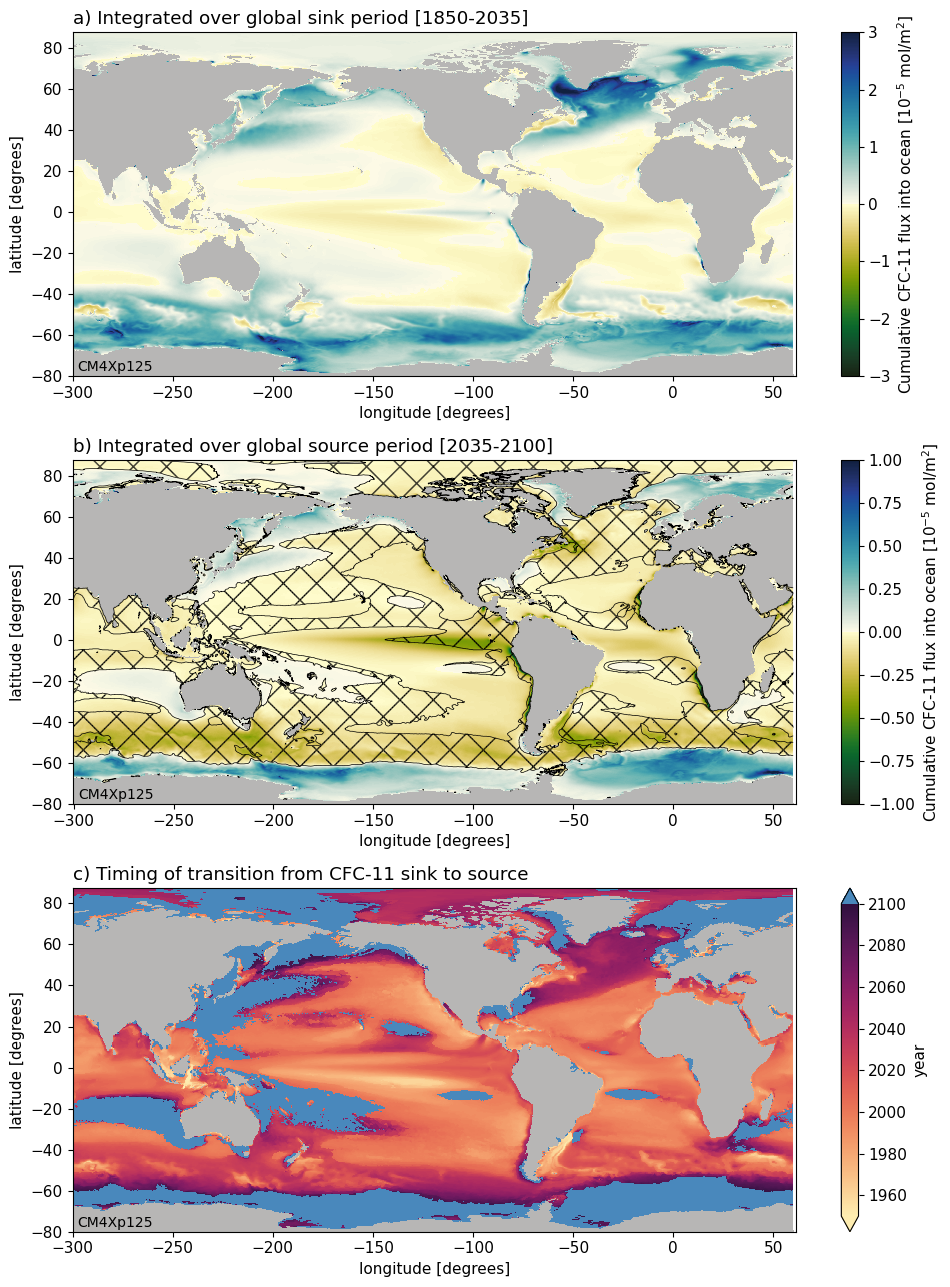

In [15]:
import cmocean
cmap = cmocean.cm.delta_r.copy()
cmap.set_bad(facecolor)

fig, axes = plt.subplots(3,1,figsize=(10,13))
inv = inv_dict["CM4Xp125"]

## Sink
plt.sca(axes[0])
fgcfc11_sink_plot = inv['fgcfc11_sink'].where(og.deptho.values > 0)
plt.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    fgcfc11_sink_plot*1e5,
    vmin=-3,
    vmax=3,
    cmap=cmap
)
plt.colorbar(label=r"Cumulative CFC-11 flux into ocean [$10^{-5}$ mol/m$^{2}$]")
plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("a) Integrated over global sink period [1850-2035]", loc="left")
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)
plt.ylim(-80, 87.5)

## Source
plt.sca(axes[1])
fgcfc11_source_plot = inv['fgcfc11_source'].where(og.deptho.values > 0)
plt.pcolormesh(
    og.geolon_c,
    og.geolat_c,
    fgcfc11_source_plot*1e5,
    vmin=-1,
    vmax=1,
    cmap=cmap
)
plt.colorbar(label=r"Cumulative CFC-11 flux into ocean [$10^{-5}$ mol/m$^{2}$]")

sink_to_source = (inv['fgcfc11_sink'] > 0) & (inv['fgcfc11_source'] < 0)
plt.contour(
    og.geolon,
    og.geolat,
    sink_to_source,
    levels=[0.5], linestyles="solid", colors="k", linewidths=0.5
)
fgcfc11_source_plot_masked = np.ma.masked_array(
    fgcfc11_source_plot,
    mask=np.logical_not(sink_to_source)
)
N = 8
plt.pcolor(
    og.geolon[N//2::N,N//2::N],
    og.geolat[N//2::N,N//2::N],
    fgcfc11_source_plot_masked[N//2::N,N//2::N],
    hatch='X',
    alpha=0.
)

plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("b) Integrated over global source period [2035-2100]", loc="left")
plt.ylim(-80, 87.5)
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)

plt.sca(axes[2])
cmap = cmocean.cm.matter.copy()
color_pick = 0.55
cmap.set_extremes(over=cmocean.cm.ice(color_pick))
pc = plt.pcolormesh(
    source_year.geolon,
    source_year.geolat,
    source_year,
    cmap=cmap,
    vmin=1950, vmax=2100,
)
plt.colorbar(pc, label="year", extend="both")
plt.pcolormesh(
    source_year.geolon,
    source_year.geolat,
    always_sink.where(always_sink)*color_pick,
    cmap=cmocean.cm.ice,
    vmin=0, vmax=1
)
plt.pcolormesh(
    source_year.geolon,
    source_year.geolat,
    source_year.deptho.where(source_year.deptho==0) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.3
)

plt.xlabel("longitude [degrees]")
plt.ylabel("latitude [degrees]")
plt.title("c) Timing of transition from CFC-11 sink to source", loc="left")
plt.ylim(-80, 87.5);
plt.annotate(
    "CM4Xp125", (-297.5, -79), rotation="horizontal",
    ha="left", va="bottom", color="k", fontsize=10
)

plt.tight_layout()
plt.savefig("../figures/Fig2_integrated_flux_cfc11.png", dpi=400, bbox_inches="tight")

### Observational validation

/vftmp/Henri.Drake/pid10200/ipykernel_5972/3732747865.py:15: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(
/vftmp/Henri.Drake/pid10200/ipykernel_5972/3732747865.py:26: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  pc = ax.pcolor(
/vftmp/Henri.Drake/pid10200/ipykernel_5972/3732747865.py:33: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  ax.pcolor(
/vftmp/Henri.Drake/pid10200/ipykernel_5972/3732

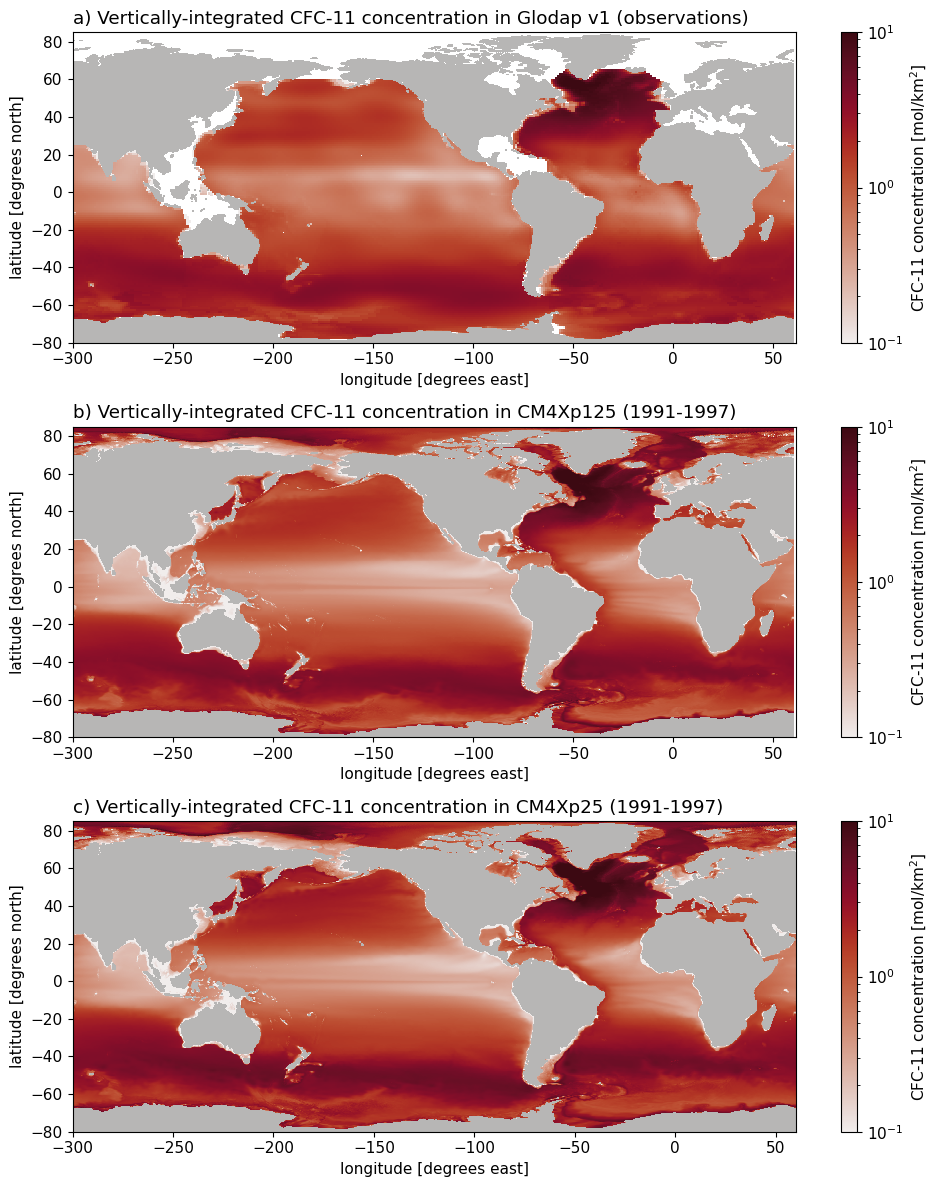

In [16]:
fig, axes = plt.subplots(3,1,figsize=(10, 12))

ax = axes[0]
cfc11_zint = (glo.CFC11*mol_per_pmol*rho0*glo.dz*m2_per_km2).sum("depth").roll(shifts={"lon":120}, roll_coords=True)
cfc11_zint = cfc11_zint.assign_coords(
    {"lon": np.mod(cfc11_zint.lon.values + 300, 360) - 300}
)
pc = ax.pcolor(
    cfc11_zint.lon,
    cfc11_zint.lat,
    cfc11_zint,
    norm=colors.LogNorm(vmin=1e-1, vmax=10),
    cmap=cmocean.cm.amp
)
ax.pcolor(
    grid._ds.geolon,
    grid._ds.geolat,
    grid._ds.deptho.where(grid._ds.deptho==0.) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.3
)
plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/km$^{2}$]")

ax = axes[1]
cfc11_zint = (grid._ds.cfc11*grid._ds.thkcello*m2_per_km2).sel(year=slice(1991,1997)).mean("year").sum("zl")
pc = ax.pcolor(
    cfc11_zint.geolon,
    cfc11_zint.geolat,
    cfc11_zint,
    norm=colors.LogNorm(vmin=1e-1, vmax=10),
    cmap=cmocean.cm.amp
)
ax.pcolor(
    grid._ds.geolon,
    grid._ds.geolat,
    grid._ds.deptho.where(grid._ds.deptho==0.) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.3
)
plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/km$^{2}$]")

ax = axes[2]
cfc11_zint = (grid_p25._ds.cfc11*grid_p25._ds.thkcello*m2_per_km2).sel(year=slice(1991,1997)).mean("year").sum("zl")
pc = ax.pcolor(
    cfc11_zint.geolon,
    cfc11_zint.geolat,
    cfc11_zint,
    norm=colors.LogNorm(vmin=1e-1, vmax=10),
    cmap=cmocean.cm.amp
)
ax.pcolor(
    grid_p25._ds.geolon,
    grid_p25._ds.geolat,
    grid_p25._ds.deptho.where(grid_p25._ds.deptho==0.) + 1,
    cmap=cmocean.cm.gray,
    vmin=0, vmax=1.3
)
plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/km$^{2}$]")

titles = [
    "a) Vertically-integrated CFC-11 concentration in Glodap v1 (observations)",
    "b) Vertically-integrated CFC-11 concentration in CM4Xp125 (1991-1997)",
    "c) Vertically-integrated CFC-11 concentration in CM4Xp25 (1991-1997)",
    ]
for ax, title in zip(axes, titles):
    ax.set_ylim(-80, 85)
    ax.set_title(title, loc="left")
    ax.set_xlabel("longitude [degrees east]")
    ax.set_ylabel("latitude [degrees north]")

fig.tight_layout()
plt.savefig("../figures/SFig1_glodap_observational_validation_zint.png", dpi=400, bbox_inches="tight")

/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/work/hfd/.conda/envs/CM4Xanalysis/lib/python3.12/site-packages/xgcm/transform.py:245: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a 

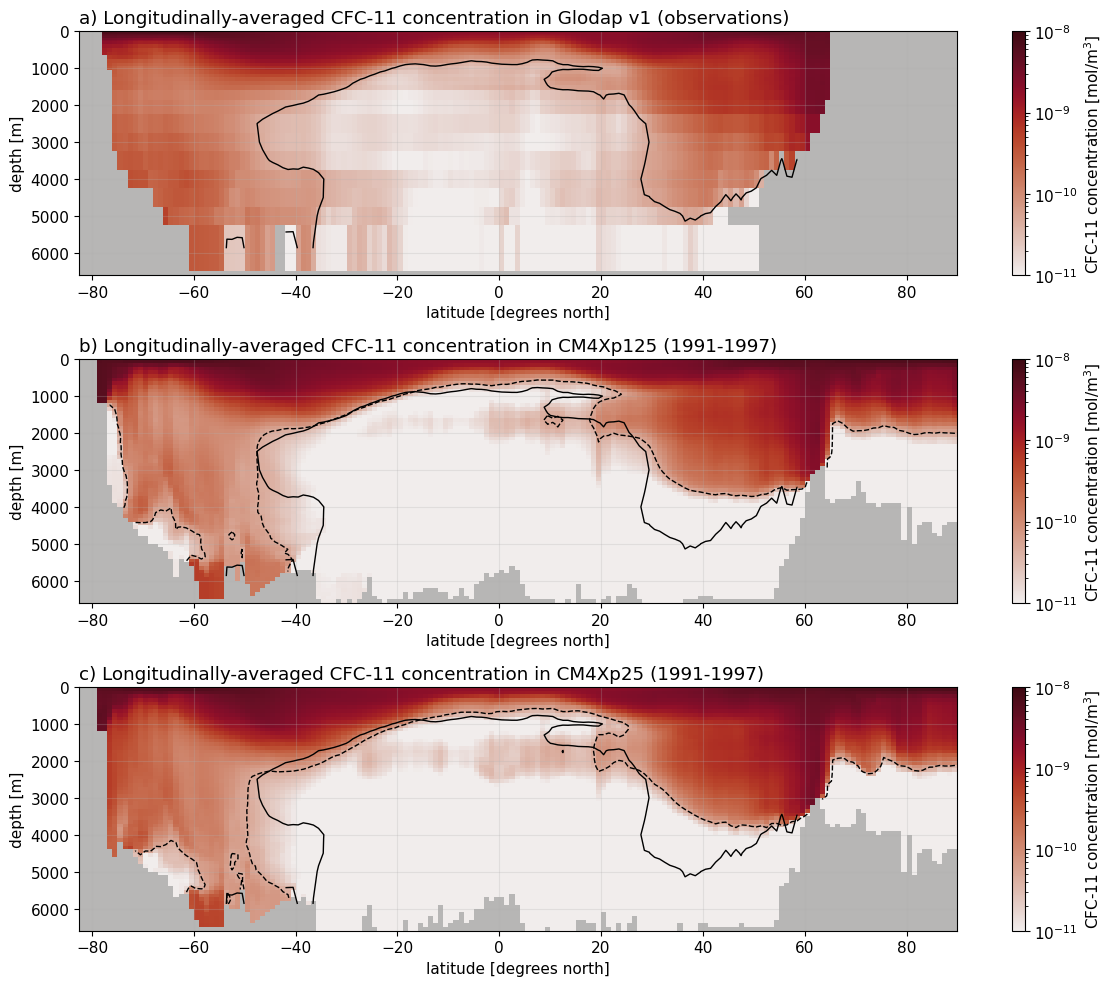

In [17]:
fig, axes = plt.subplots(3,1, figsize=(12, 10))

# Glodap v1
ax = axes[0]
ax.set_facecolor(facecolor)

dlat = 1.
lat_bins_glodap = np.arange(-90., 90.+dlat, dlat)
d_bins_glodap  = glo.depth_bnds

cfc11_zlat_av = (glo.CFC11*mol_per_pmol*rho0).mean("lon", skipna=True)
cfc11_zlat_av_glodap = cfc11_zlat_av.copy()

pc = ax.pcolormesh(
    lat_bins_glodap,
    d_bins_glodap,
    cfc11_zlat_av,
    norm=colors.LogNorm(vmin=1e-11, vmax=1e-8),
    cmap=cmocean.cm.amp
)
ct = ax.contour(
    0.5*(lat_bins_glodap[:-1]+lat_bins_glodap[1:]),
    0.5*(d_bins_glodap.values[:-1]+d_bins_glodap.values[1:]),
    cfc11_zlat_av_glodap,
    levels=[5e-11],
    colors="k",
    linewidths=1.
)
plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/m$^{3}$]")

# CM4Xp125
ax = axes[1]
ax.set_facecolor(facecolor)

dlat = 1.
lat_bins = np.arange(-90., 90+dlat, dlat)
lat_centers = np.arange(-90.+dlat/2, 90+dlat/2, dlat)

dz = 100.
zi = np.arange(0, 7000+dz, dz)
zl = np.arange(dz/2, 7000+dz/2, dz)

dV = grid.transform(
    (ds.thkcello*grid._ds.areacello).fillna(0.),
    "Z",
    xr.DataArray(zi, dims=("zi",)),
    target_data=ds.thkcello_i.fillna(0.).cumsum("zi"),
    method="conservative"
).rename({"zi": "zl"}).assign_coords({"zl": zl})

cfc11_content_z = grid.transform(
    (ds.cfc11*ds.thkcello*grid._ds.areacello).fillna(0.),
    "Z",
    xr.DataArray(zi, dims=("zi",)),
    target_data=ds.thkcello_i.fillna(0.).cumsum("zi"),
    method="conservative"
).rename({"zi": "zl"}).assign_coords({"zl": zl})

weights = cfc11_content_z.sel(year=slice(1991,1997)).fillna(0.)
cfc11_zlat_bins = xhistogram.xarray.histogram(
    grid._ds.geolat,
    bins=[lat_bins],
    dim=("xh", "yh", "year"),
    weights=weights,
    bin_dim_suffix="",
    block_size=None,
    keep_coords=True
).assign_coords({"zl": zl})

weights = dV.sel(year=slice(1991,1997)).fillna(0.)
V_zlat_bins = xhistogram.xarray.histogram(
    grid._ds.geolat,
    bins=[lat_bins],
    dim=("xh", "yh", "year"),
    weights=weights,
    bin_dim_suffix="",
    block_size=None,
    keep_coords=True
).assign_coords({"zl": zl})

cfc11_zlat_av = cfc11_zlat_bins/V_zlat_bins

pc = ax.pcolormesh(
    lat_bins,
    zi,
    cfc11_zlat_av,
    norm=colors.LogNorm(vmin=1e-11, vmax=1e-8),
    cmap=cmocean.cm.amp
)
plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/m$^{3}$]")
ct = ax.contour(
    lat_centers,
    zl,
    cfc11_zlat_av,
    levels=[5e-11],
    colors="k",
    linestyles="--",
    linewidths=1.
)
ct = ax.contour(
    0.5*(lat_bins_glodap[:-1]+lat_bins_glodap[1:]),
    0.5*(d_bins_glodap.values[:-1]+d_bins_glodap.values[1:]),
    cfc11_zlat_av_glodap,
    levels=[5e-11],
    colors="k",
    linewidths=1.
)

# CM4Xp25
ax = axes[2]
ax.set_facecolor(facecolor)

dlat = 1.
lat_bins = np.arange(-90., 90+dlat, dlat)

dV = grid.transform(
    (ds_p25.thkcello*grid_p25._ds.areacello).fillna(0.),
    "Z",
    xr.DataArray(zi, dims=("zi",)),
    target_data=ds_p25.thkcello_i.fillna(0.).cumsum("zi"),
    method="conservative"
).rename({"zi": "zl"}).assign_coords({"zl": zl})

cfc11_content_z = grid_p25.transform(
    (ds_p25.cfc11*ds_p25.thkcello*grid_p25._ds.areacello).fillna(0.),
    "Z",
    xr.DataArray(zi, dims=("zi",)),
    target_data=ds_p25.thkcello_i.fillna(0.).cumsum("zi"),
    method="conservative"
).rename({"zi": "zl"}).assign_coords({"zl": zl})

weights = cfc11_content_z.sel(year=slice(1991,1997)).fillna(0.)
cfc11_zlat_bins = xhistogram.xarray.histogram(
    grid_p25._ds.geolat,
    bins=[lat_bins],
    dim=("xh", "yh", "year"),
    weights=weights,
    bin_dim_suffix="",
    block_size=None,
    keep_coords=True
).assign_coords({"zl": zl})

weights = dV.sel(year=slice(1991,1997)).fillna(0.)
V_zlat_bins = xhistogram.xarray.histogram(
    grid_p25._ds.geolat,
    bins=[lat_bins],
    dim=("xh", "yh", "year"),
    weights=weights,
    bin_dim_suffix="",
    block_size=None,
    keep_coords=True
).assign_coords({"zl": zl})

cfc11_zlat_av = cfc11_zlat_bins/V_zlat_bins

pc = ax.pcolormesh(
    lat_bins,
    zi,
    cfc11_zlat_av,
    norm=colors.LogNorm(vmin=1e-11, vmax=1e-8),
    cmap=cmocean.cm.amp
)
plt.colorbar(pc, ax=ax, label=r"CFC-11 concentration [mol/m$^{3}$]")
ct = ax.contour(
    lat_centers,
    zl,
    cfc11_zlat_av,
    levels=[5e-11],
    colors="k",
    linestyles="--",
    linewidths=1.
)
ct = ax.contour(
    0.5*(lat_bins_glodap[:-1]+lat_bins_glodap[1:]),
    0.5*(d_bins_glodap.values[:-1]+d_bins_glodap.values[1:]),
    cfc11_zlat_av_glodap,
    levels=[5e-11],
    colors="k",
    linewidths=1.
)

titles = [
    "a) Longitudinally-averaged CFC-11 concentration in Glodap v1 (observations)",
    "b) Longitudinally-averaged CFC-11 concentration in CM4Xp125 (1991-1997)",
    "c) Longitudinally-averaged CFC-11 concentration in CM4Xp25 (1991-1997)",
]
for ax, title in zip(axes, titles):
    ax.set_title(title, loc="left")
    ax.set_xlabel("latitude [degrees north]")
    ax.set_ylabel("depth [m]")
    ax.set_ylim(6600, 0)
    ax.set_xlim(-82.5, 90)
    ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.savefig("../figures/SFig2_glodap_observational_validation_lonav.png", dpi=400, bbox_inches="tight")